In [1]:
import numpy as np
import matplotlib.pyplot as plt
from eleanor.source import Source
from eleanor.targetdata import TargetData
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from lightkurve.lightcurve import LightCurve as LC

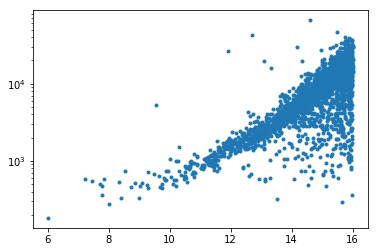

In [2]:
%matplotlib inline
tmag_cdpp = np.loadtxt('/Users/AdinaFeinstein/Downloads/tmag_cdpp.txt')
plt.semilogy(tmag_cdpp[:,0], tmag_cdpp[:,1], '.')
plt.show()

In [3]:
ra  = Angle(68.959732, u.deg)
dec = Angle(-64.02704, u.deg)

star = Source(coords=SkyCoord(ra,dec), sector=1)
data = TargetData(star, do_pca=True, height=7)

https://users.flatironinstitute.org/dforeman/public_www/tess/postcards_test/s0001/4-1/ hlsp_eleanor_tess_ffi_postcard-s0001-4-1-cal-0902-1078.fits


KeyError: "Key 'BKG' does not exist."

In [ ]:
plt.imshow(data.aperture, origin='lower')
plt.show()

In [ ]:
plt.imshow(data.tpf[0], origin='lower')
plt.colorbar()
plt.show()

In [ ]:
plt.plot(data.time, data.flux_bkg, '.')
plt.show()

In [ ]:
q = data.quality == 0
plt.plot(data.time[q], data.raw_flux[q], 'k.')
plt.plot(data.time[q][0:626], data.corr_flux[q][0:626], 'r.')

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(12,4))
ax1.plot(data.time, data.centroid_xs, '.')
ax2.plot(data.time, data.centroid_ys, '.')

In [ ]:
plt.scatter(data.centroid_xs, data.centroid_ys, s=3, c=data.time)

In [ ]:
lc_obj = LC(time=data.time[q], flux=data.corr_flux[q])
flat_lc = lc_obj.flatten()#.plot()
flat_lc.plot()

between = np.where((data.time >= 1333) & (data.time <= 1334.75) & (data.quality == 0))
print(np.std(flat_lc.flux[between])/np.sqrt(2)*1e6)

In [ ]:
first_lc = LC(time=data.time[between], flux=data.corr_flux[between])
first_lc.estimate_cdpp(transit_duration=2)
#np.std(first_lc.flux/np.nanmedian(first_lc.flux))/np.sqrt(2)*1e6

# PLAYING WITH REMOVING REALLY FAR AWAY CENTROIDS

In [ ]:
x = data.centroid_xs
y = data.centroid_ys

In [ ]:
from scipy.stats import chisquare, linregress
%matplotlib inline

plt.figure(figsize=(15,6))

x1 = x[0:626]
y1= y[0:626]
x2 = x[626:len(x)+1]
y2 = y[626:len(y)+1]

plt.plot(x1, y1, 'k.')
plt.plot(x2, y2, 'g.')
#plt.plot(x[626:len(y)], y[626:len(y)], 'r.')

mask1 = np.zeros(len(x1))
mask2 = np.zeros(len(x2))

def outliers(x, y, poly, mask):
    distance = (y - poly[0]*x - poly[1])/np.sqrt(poly[0]**2+1**2)
    std = np.std(distance)
    ind = np.where((distance > 2*std) | (distance < -2*std))[0]
    mask[ind] = 1
    return mask


for deg in np.arange(0,10,1):
    poly1  = np.polyfit(x1[mask1==0], y1[mask1==0], 1)
    poly2  = np.polyfit(x2[mask2==0], y2[mask2==0], 1)
    mask1  = outliers(x1, y1, poly1, mask1)
    mask2  = outliers(x2, y2, poly2, mask2)

p1 = np.poly1d(poly1)
p2 = np.poly1d(poly2)

plt.plot(x1[mask1!=0], y1[mask1!=0], 'r.', ms=8)
plt.plot(x2[mask2!=0], y2[mask2!=0], 'y.', ms=8)

plt.plot(x1, p1(x1), 'r')
plt.plot(x2, p2(x2), 'y')
plt.show()
plt.close()

totmask = np.append(mask1, mask2)
plt.plot(x[totmask==0], y[totmask==0], 'b.')
plt.show()

In [ ]:
%matplotlib inline
newQ = totmask
Q = newQ == 0
plt.figure(figsize=(16,5))
#plt.plot(data.time[q], data.corr_flux[q], 'k.')
#plt.plot(data.time[Q], data.corr_flux[Q], 'g.')
plt.plot(data.time[~q], data.corr_flux[~q], 'k.', ms=10)
plt.plot(data.time[~Q], data.corr_flux[~Q], '.')
plt.show()
print(len(np.where(newQ != 0)[0]))

# Using 2-minute targets to get quality flags for FFIs

In [ ]:
from astropy.io import fits
twoMin = fits.open('hlsp_tess-data-alerts_tess_phot_00025155310-s01_tess_v1_lc.fits')
twoMinTime = twoMin[1].data['TIME']
twoMinQual = twoMin[1].data['QUALITY']
cadence    = twoMin[1].data['CADENCENO']

In [ ]:
perFFIcad = []
for i in range(len(data.time)-1):
    where = np.where( (twoMinTime >= data.time[i]) & 
                     (twoMinTime < data.time[i+1]))[0]
    perFFIcad.append(where)
perFFIcad.append(np.where(twoMinTime > data.time[int(len(data.time)-1):])[0])
perFFIcad = np.array(perFFIcad)

In [ ]:
ffi_apply = int('1111101',2)
convolve_ffi = []
for cadences in perFFIcad:
    v = np.bitwise_or.reduce(twoMinQual[cadences])
    convolve_ffi.append(v)
convolve_ffi = np.array(convolve_ffi)

In [ ]:
flags = np.bitwise_and(convolve_ffi, ffi_apply)

In [ ]:
totmask = np.append(mask1, mask2)*4096
quality = totmask+flags

In [ ]:
fig, ax = plt.subplots(figsize=(20,9))
plt.plot(data.time, data.corr_flux, 'k.')
plt.plot(data.time[quality==0], data.corr_flux[quality==0], 'r')
#ax.plot(data.time[quality==0][0:490], data.pca_flux[quality==0][0:490], 'white',
#       linewidth=4)
ax.set_facecolor('k')
ax.set_ylim(6800,7500)
plt.show()

In [ ]:
import sys, os

In [ ]:
direc = '/Users/AdinaFeinstein/Downloads/'
files = os.listdir(direc)
files = [i for i in files if '-s01_tess' in i]

In [ ]:
twoMinQuality = []
camera, chip = [], []
for i,f in enumerate(files):
    hdu = fits.open(direc+f)
    qual = hdu[1].data['QUALITY']
    camera.append(hdu[0].header['CAMERA'])
    chip.append(hdu[0].header['CCD'])
    twoMinQuality.append(qual)
print(len(chip))
#    if i == 0:
#        time = hdu[1].data['TIME']-hdu[1].data['TIMECORR']
#    plt.plot(time - (hdu[1].data['TIME']-hdu[1].data['TIMECORR']))
#plt.show()

In [ ]:
plt.figure(figsize=(16,10))

ffi_apply = int('100010101111',2)
convolve_ffi = []
for i in range(len(files)):
    hdu = fits.open(direc+files[i])
    print(direc+files[i])
    qual = hdu[1].data['QUALITY']
    flags = np.bitwise_and(qual, ffi_apply)
    plt.plot(hdu[1].data['CADENCENO'], flags, '.', ms=10, 
             label=' '.join(str(e) for e in [camera[i], chip[i], files[i]]))
    convolve_ffi.append(flags)
plt.legend()
plt.show()


In [ ]:
convolve_ffi = np.array(convolve_ffi)
for i in range(len(convolve_ffi[0])):
    print(convolve_ffi[:,i])

In [ ]:
%matplotlib inline
weird = fits.open('/Users/AdinaFeinstein/Downloads/hlsp_tess-data-alerts_tess_phot_00140068425-s01_tess_v1_lc.fits')
q = weird[1].data['QUALITY'] == 0
plt.plot(weird[1].data['TIME'][q], weird[1].data['PDCSAP_FLUX'][q], '.')
plt.show()

In [ ]:
plt.plot(weird[1].data['TIME'][9600], weird[1].data['QUALITY'][9600],'.')

In [ ]:
weird[1].data['TIME'][9600]